© 2018 Suzy Beeler. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT) 

This exercise was generated from a Jupyter notebook. You can download the notebook [here](fly_elongation_rate.ipynb).
___

# Objective 

In this tutorial we will estimate the rate of RNAP elongation in developing *Drosophila* embryos by analyzing the data from transcription experiments performed using the MS2 mRNA labeling. MS2 loops were placed both at the 5' end and at the 3' end of the reporter gene, and each attracts fluorescent probes of different colors (red and green, respectively). By measuring the delay in the transcription of the MS2 loops at the 3' end and knowing the length of the reporter gene, we will determine the rate of RNAP transcription.

# Determining MS2 spot intensity over time

In [1]:
# Import the necessary modules
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# For pretty plots
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14, \
    'xtick.labelsize' : 14, 'ytick.labelsize' : 14}
sns.set(rc=rc)

# For bulk acquisition of filenames
import glob

# For importing bacterial images
import skimage.io

To figure out how we might analyze these iamges, let's take a look at a sample image frame from a 3'-labeled construct.

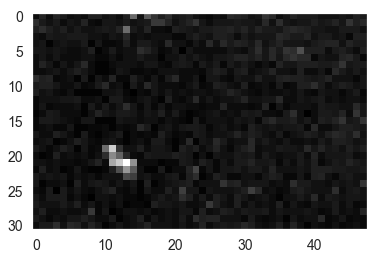

In [2]:
# Import a sample image
im = skimage.io.imread('./data/MS2_nuclei/nuc1/green28.tif')

# Show the image
plt.imshow(im, cmap = plt.cm.Greys_r)

# Turn the grid off
plt.grid(False)

The bright spot indicates that transcription is taking place, but there is also quite a bit of background fluorescence. Our goal is to determine the moment when transcription first started (i.e. the moment when the spot appears). To do that, we need a measure of the spot fluorescence, which we can track over time. We could imagine some rigorous ways of doing this, such as fitting a two-dimensional Gaussian to the spot and quantifying the height of the peak over time. 

For our purposes, we will take a simpler approach and will sum the pixel intensities of the 5 brightest pixels and take that sum as a fluorescence measure of the spot. Let's write a function that will iterate over files for one nucleus and return fluorescence values as an array.

In [3]:
def spot_intensity(file_name_list):
    """
    This function takes in a list of file names and returns
    the spot intensity as an array
    """
    
    # Number of frames
    n_frames = len(file_name_list)

    # Array to store intensity values
    intensities = np.zeros(n_frames)

    for i in range(n_frames):

        # Read the frame
        im = skimage.io.imread(file_name_list[i])

        # Flatten the image into a 1-d array and sort in ascending order
        im_sorted = np.sort(im.flatten())

        # Reverse the order 
        im_reversed = np.flip(im_sorted)

        # Calculate the intensity of the spot, summing 5 brightest pixels
        intensities[i] = np.sum(im_reversed[0:5])
        
    # return the array of intensities
    return intensities

Let's try this function out on the green channel of the first nucleus and plot the results.

Text(0,0.5,"3' Fluoresence (A.U.)")

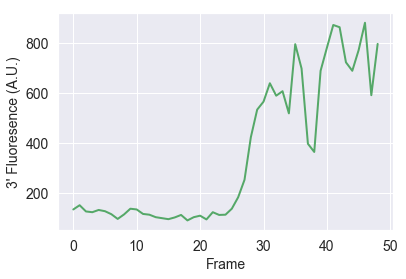

In [4]:
# colelct file names for nucleus 1 in the green channel
green1_names = sorted(glob.glob('./data/MS2_nuclei/nuc1/green*.tif'))

# call our function to caculate the spot intensity
green1_int = spot_intensity(green1_names)

# plot the results
plt.plot(green1_int, color = 'g')
plt.xlabel('Frame')
plt.ylabel('3\' Fluoresence (A.U.)')

We can see that there is a sharp increase in the fluorescence of the green channel approximately at the 25th frame, corresponding to the beginning of transcription at the 3' end.

# Comparing the 5' and 3' MS2 constructs

Let's repeat the same procedure for the red channel at the 5' end.

Text(0,0.5,"3' Fluoresence (A.U.)")

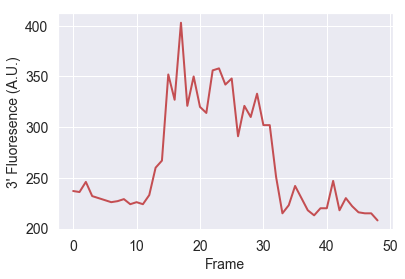

In [5]:
# colelct file names for nucleus 1 in the green channel
red1_names = sorted(glob.glob('./data/MS2_nuclei/nuc1/red*.tif'))

# call our function to caculate the spot intensity
red1_int = spot_intensity(red1_names)

# plot the results
plt.plot(red1_int, color = 'r')
plt.xlabel('Frame')
plt.ylabel('3\' Fluoresence (A.U.)')

For this 5' construct, we see that the fluorescence intensity comes up much earlier. Let's plot these two traces in the same figure for comparison.

Text(0,0.5,'Fluoresence (A.U.)')

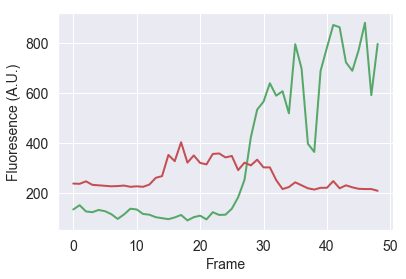

In [6]:
plt.plot(green1_int, color='g')
plt.plot(red1_int, color='r')
plt.xlabel('Frame')
plt.ylabel('Fluoresence (A.U.)')

These two traces are hard to compare since their maximum values differ. Let's rescale the fluorescence values to be $0$ at the first time point and to take a maximum value $1$.

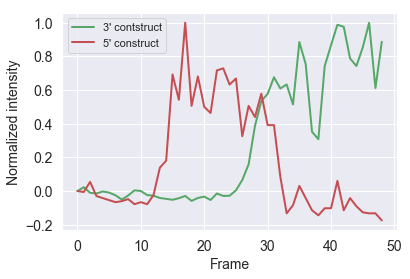

In [7]:
# rescale the intensities 
green1_norm = (green1_int - green1_int[0])/(np.max(green1_int) - green1_int[0])
red1_norm = (red1_int - red1_int[0])/(np.max(red1_int) - red1_int[0])

# and plot
plt.plot(green1_norm, color = 'g')
plt.plot(red1_norm, color = 'r')
plt.xlabel('Frame')
plt.ylabel('Normalized intensity')
plt.legend(["3' contstruct","5' construct"])

Much better! Now we can clearly see that delay in the 3' end. To determine the rate of transcription, we can set a threshold for the fluorescence and find the frame number where each construct crosses this threshold. We can then convert frame numbers into time, knowing that each frame corresponds to $10$ seconds. Finally, we can get the transcription rate by knowing that there are $4500$ basepairs between the two constructs.  

In [8]:
# intensity threshold
thresh = 0.2

# positions where threshold condition is met
red_positions = np.where(red1_norm > thresh)
green_positions = np.where(green1_norm > thresh)

# pick the first frame that crossed the threshold
red_start = red_positions[0][0]
green_start = green_positions[0][0]

# calculate difference in number of frames and convert to time
frame_diff = green_start - red_start
time_diff = frame_diff * 10

# calculate rate of transcription
trans_rate = 4500/time_diff

# display the transcription rate
print('Transcription rate ' + str(np.round(trans_rate,1)) + ' bp/sec')

Transcription rate 34.6 bp/sec


Now we iterate over all the nuclei and for each of them repeat the set of steps that we implemented for one nucleus, recording the moments of transcription start at both the 3' and the 5' ends.

In [9]:
# Names of directories that contain nuclei
nuclei_names = glob.glob('data/ms2_elongation/*')

# Number of nuclei
n_nuclei = len(nuclei_names)

# Arrays to store the times where the spot appears in green and blue channels
spot_times_g = np.zeros(n_nuclei)
spot_times_r = np.zeros(n_nuclei)

# Iterate over all nuclei
for i in range(n_nuclei):
    
    # -------------------- GREEN CHANNEL --------------------
    
    # All frames in green channel for ith nucleus
    frame_names_g = sorted(glob.glob(nuclei_names[i] + '/green*'))
    
    # Number of frames in the green channel
    n_frames_g = len(frame_names_g)
    
    # Array to store the intensity values
    intensity_g = np.zeros(n_frames_g)
    
    # Iterate over all frames in the green channel
    for j in range(n_frames_g):
        
        # Read the image
        im = skimage.io.imread(frame_names_g[j])
        
        # Sort the pixel value
        im_sort = np.sort(im.flatten())
        
        # Calculate the intensity value
        intensity_g[j] = np.sum(im_sort[-5:])
    
    # Positions where intensity is greater than the threshold
    positions_g = np.where(intensity_g > thresh_green)
    
    # First position where the intenisty is greater than the threshold
    index_spot_g = positions_g[0][0]
    
    # Time when the intensity first exceeds the threshold
    spot_times_g[i] = times[index_spot_g]
    
    
    # -------------------- RED CHANNEL --------------------
    
    # All frames in red channel for ith nucleus
    frame_names_r = sorted(glob.glob(nuclei_names[i] + '/red*'))
    
    # Number of frames in the red channel
    n_frames_r = len(frame_names_r)
    
    # Array to store the intensity values
    intensity_r = np.zeros(n_frames_r)
    
    # Iterate over all frames in the red channel
    for j in range(n_frames_r):
        
        # Read the image
        im = skimage.io.imread(frame_names_r[j])
        
        # Sort the pixel value
        im_sort = np.sort(im.flatten())
        
        # Calculate the intensity value
        intensity_r[j] = np.sum(im_sort[-5:])
    
    # Positions where intensity is greater than the threshold
    positions_r = np.where(intensity_r > thresh_red)
    
    # First position where the intenisty is greater than the threshold
    index_spot_r = positions_r[0][0]
    
    # Time when the intensity first exceeds the threshold
    spot_times_r[i] = times[index_spot_r]